In [222]:
import subprocess
import calendar
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('result/strava_all_activities.csv')
print('Dataframe Shape:', df.shape)
df.head()


Dataframe Shape: (1043, 60)


,Unnamed: 0,Unnamed: 0.1,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,...,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_watts,kilojoules,device_watts,average_temp
0,0,0,2,Ez Run,6530.2,1801,1954,71.4,Run,Run,...,10.0,56603883,1,a8760126713,gd}|Gt{vvT?r@DlAAhC@RB|BCvD?jB@TBH?HChA@LBDRDX...,2,NaN,NaN,NaN,NaN
1,1,1,2,Afternoon Run,9666.8,3065,5110,60.4,Run,Run,...,17.0,56603883,1,a8754986960,{k||GfaxvTj@@hAEtAH|@EnACZ@|AEhAB^ARE|@Dn@L\XT...,2,NaN,NaN,NaN,NaN
2,2,2,2,Lunch Run,5049.4,2175,4240,6.3,Run,Run,...,7.0,56603883,1,a8749314572,wc}|Gd}vvTFtACxC@hBAj@?dGEtA@|ALjDHh@Fl@Nf@BDJ...,2,NaN,NaN,NaN,NaN
3,3,3,2,Ez Shakeout,4888.1,1217,1217,16.3,Run,Run,...,10.0,56603883,1,a8743496692,kz}|G|avvTk@D]G{@A[Fs@EyAF_A@aCG_AD[CkBBuBKw@@...,2,NaN,NaN,NaN,NaN
4,4,4,2,Afternoon Run,7242.1,1890,1890,0.0,Run,Run,...,NaN,56603883,1,a8743519976,NaN,2,NaN,NaN,NaN,NaN


In [223]:
df2 = pd.read_csv('MeetData2.csv')
df2.head()

,Meet Name,Event,start_date,Result,Place,PR
0,2023 Big Sky Indoor Track & Field Championships,800,2023-02-24,01:57.7,22nd (P),0
1,Bobcat Performance,800,2023-02-10,01:57.4,4th (F),0
2,2023 WSU Open,800,2023-02-03,01:56.2,17th (F),0
3,2023 Lauren McCluskey Memorial,800,2023-01-20,01:58.3,12th (F),0
4,2023 Spokane Indoor Challenge,800,2023-01-13,01:55.8,6th (F),0


In [224]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
print('Null Data:', df.isnull().sum().sum())
list(filter(lambda x: x[1]>0, null_df))

Null Data: 7888


[['workout_type', 974],
 ['location_city', 1043],
 ['location_state', 1043],
 ['location_country', 104],
 ['gear_id', 186],
 ['average_cadence', 116],
 ['average_heartrate', 114],
 ['max_heartrate', 114],
 ['elev_high', 57],
 ['elev_low', 57],
 ['upload_id', 8],
 ['upload_id_str', 8],
 ['external_id', 8],
 ['suffer_score', 114],
 ['map.summary_polyline', 66],
 ['average_watts', 948],
 ['kilojoules', 948],
 ['device_watts', 939],
 ['average_temp', 1041]]

In [225]:
selected_columns = ['distance', 'moving_time', 'elapsed_time',
                    'total_elevation_gain', 'type','sport_type', 'id', 'start_date',
                    'start_date_local','location_country', 'achievement_count', 'kudos_count',
                    'comment_count','athlete_count', 'start_latlng',
                    'end_latlng', 'average_speed', 'max_speed', 'average_cadence',
                    'average_heartrate', 'max_heartrate', 'elev_high','elev_low',
                    'upload_id', 'external_id', 'pr_count', 'map.summary_polyline']
df = df[selected_columns]

In [226]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')
df = df.sort_values(by='start_date_local')

df['weekday'] = df['start_date_local'].map(lambda x: x.weekday)
df['start_time'] = df['start_date_local'].dt.time
df['start_time'] = df['start_time'].astype(str)
df['start_date'] = df['start_date_local'].dt.date

df = df.drop('start_date_local', 1)
df.head()

/Users/willd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == "__main__":


,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time
642,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,NaN,NaN,1208.4,1120.3,3.608829e+09,stripped_health_data_56603883_1588289662.gpx,0,wgi|Gj_mvThBICCx@?LGFZBD@EDNGCc@Ec@Fu@PGDO@EHS...,5,09:31:43
641,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,NaN,NaN,989.4,968.5,3.608829e+09,stripped_health_data_56603883_1588289662.gpx,4,}q`}GtxvvT?b@CJ?XELFVFJAJCH@FOb@@^CHLpBAdABVDh...,0,15:38:21
640,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,NaN,NaN,983.3,974.3,3.608829e+09,stripped_health_data_56603883_1588289661.gpx,0,em_}GhruvTPIJVNH@UBB@OFBDH@\AIH@HLb@ERDHEJDBTN...,1,15:34:46
639,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,NaN,NaN,979.1,975.8,3.608829e+09,stripped_health_data_56603883_1588289661.gpx,0,mr||GrywvTS@aCCo@DQLKRCJC\BZDXNRNLRBtBIl@?RAPI...,1,16:07:54
638,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,NaN,NaN,979.1,975.8,3.608829e+09,stripped_health_data_56603883_1588289661.gpx,0,qr||GnywvTCAQBIAIJcCDSBOHMPEVAZFXJTDHPLT@`DC\E...,1,16:16:09


In [227]:
df = df.drop(df[(df.distance < 1) & (df.type == 'Run')].index)
df = df.drop(df[(df.distance < 1) & (df.type == 'Ride')].index)
df = df.drop(df[df.average_speed > 30].index)
df = df.reset_index(drop=True)

df['elev_high'] = df['elev_high'].fillna(value=0)
df['elev_low'] = df['elev_low'].fillna(value=0)
df['upload_id'] = df['upload_id'].fillna(value='unknown')
df['external_id'] = df['external_id'].fillna(value='unknown')
df['map.summary_polyline'] = df['map.summary_polyline'].fillna(value='unknown')
df['average_cadence'] = df['average_cadence'].fillna(value=df['average_cadence'].mean())
df['average_heartrate'] = df['average_heartrate'].fillna(value=df['average_heartrate'].mean())
df['max_heartrate'] = df['max_heartrate'].fillna(value=df['max_heartrate'].mean())

df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance_km'] = round(df['distance'] / 1000, 2)
df['pace'] = df['moving_time_minutes'] / df['distance_km']
df['avg_speed_kmh'] = round(60/df['pace'], 2)
df['max_speed_kmh'] = round(df['max_speed']*3.6, 2)

df['elev'] = df['elev_high'] - df['elev_low']
df['year']= df['start_date'].map(lambda x: x.year)

In [97]:
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,map.summary_polyline,weekday,start_time,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
0,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,wgi|Gj_mvThBICCx@?LGFZBD@EDNGCc@Ec@Fu@PGDO@EHS...,5,09:31:43,31.33,6.82,4.593842,13.06,28.08,88.1,2020
1,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,}q`}GtxvvT?b@CJ?XELFVFJAJCH@FOb@@^CHLpBAdABVDh...,0,15:38:21,49.32,12.30,4.009756,14.96,40.32,20.9,2020
2,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,em_}GhruvTPIJVNH@UBB@OFBDH@\AIH@HLb@ERDHEJDBTN...,1,15:34:46,12.97,3.04,4.266447,14.06,32.04,9.0,2020
3,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,mr||GrywvTS@aCCo@DQLKRCJC\BZDXNRNLRBtBIl@?RAPI...,1,16:07:54,4.65,1.48,3.141892,19.10,20.88,3.3,2020
4,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,qr||GnywvTCAQBIAIJcCDSBOHMPEVAZFXJTDHPLT@`DC\E...,1,16:16:09,4.65,1.50,3.100000,19.35,22.68,3.3,2020


In [98]:
def get_city_state_from_value(value):
    value = value.replace('[','').replace(']','').split(',')
    if value != ['']:
        location = geolocator.reverse(', '.join(value))
        result = f'{location[0].split(",")[1]}, {location[0].split(",")[1]}'
    else:
        result = 'unknown'
    return result

In [217]:
geolocator = Nominatim(user_agent="strava_exploration_data")
df['location'] = df['start_latlng'].map(get_city_state_from_value)

715     218.0
656     211.0
181     210.0
285     209.0
1016    208.0
1038    205.0
775     204.0
145     203.0
160     203.0
213     203.0
Name: max_heartrate, dtype: float64


In [228]:
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,map.summary_polyline,weekday,start_time,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
0,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,wgi|Gj_mvThBICCx@?LGFZBD@EDNGCc@Ec@Fu@PGDO@EHS...,5,09:31:43,31.33,6.82,4.593842,13.06,28.08,88.1,2020
1,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,}q`}GtxvvT?b@CJ?XELFVFJAJCH@FOb@@^CHLpBAdABVDh...,0,15:38:21,49.32,12.30,4.009756,14.96,40.32,20.9,2020
2,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,em_}GhruvTPIJVNH@UBB@OFBDH@\AIH@HLb@ERDHEJDBTN...,1,15:34:46,12.97,3.04,4.266447,14.06,32.04,9.0,2020
3,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,mr||GrywvTS@aCCo@DQLKRCJC\BZDXNRNLRBtBIl@?RAPI...,1,16:07:54,4.65,1.48,3.141892,19.10,20.88,3.3,2020
4,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,qr||GnywvTCAQBIAIJcCDSBOHMPEVAZFXJTDHPLT@`DC\E...,1,16:16:09,4.65,1.50,3.100000,19.35,22.68,3.3,2020


In [229]:
df['hr_over_170'] = np.where(df['max_heartrate']>=170, True, False)
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,weekday,start_time,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,hr_over_170
0,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,5,09:31:43,31.33,6.82,4.593842,13.06,28.08,88.1,2020,False
1,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,0,15:38:21,49.32,12.30,4.009756,14.96,40.32,20.9,2020,False
2,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,1,15:34:46,12.97,3.04,4.266447,14.06,32.04,9.0,2020,False
3,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,1,16:07:54,4.65,1.48,3.141892,19.10,20.88,3.3,2020,False
4,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,1,16:16:09,4.65,1.50,3.100000,19.35,22.68,3.3,2020,False


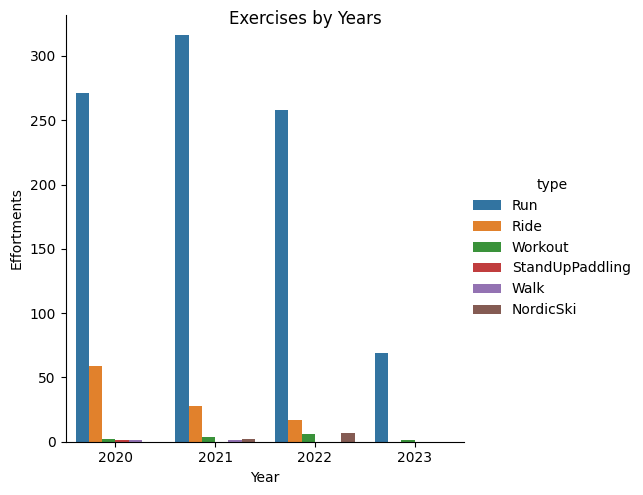

In [318]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercises by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

Text(0.5, 1.0, 'Exercise Time vs Max Heartrate')

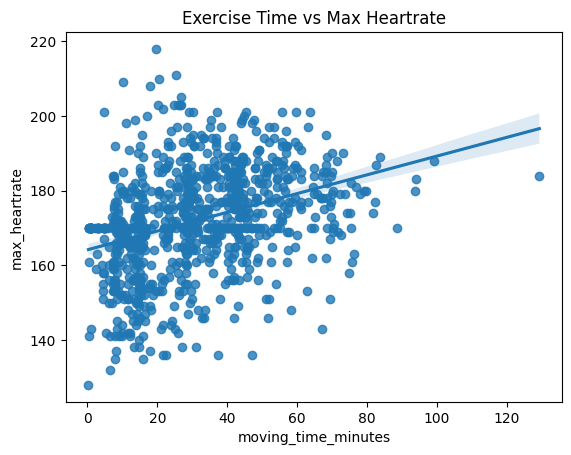

In [319]:
runs = df.loc[df['type'] == 'Run']
sns.regplot(x='moving_time_minutes', y = 'max_heartrate', data=runs).set_title("Exercise Time vs Max Heartrate")

Text(0.5, 1.0, 'Distance vs Max Heartrate')

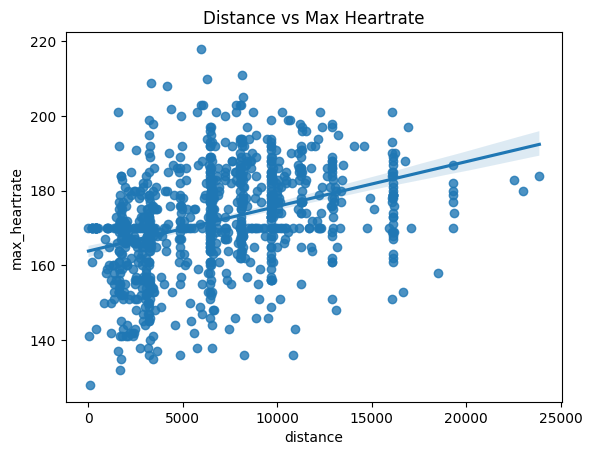

In [234]:
sns.regplot(x='distance', y = 'max_heartrate', data=runs).set_title("Distance vs Max Heartrate")

<AxesSubplot:xlabel='weekday'>

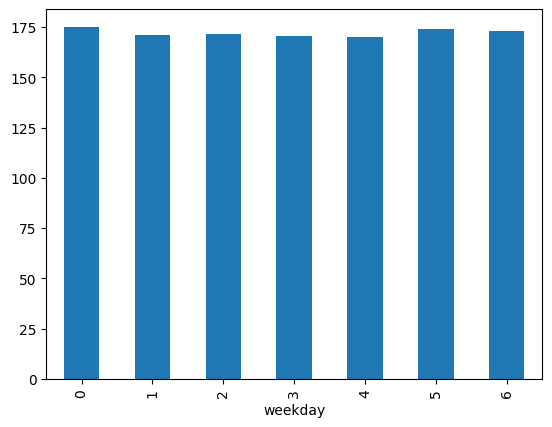

In [235]:
runs.groupby('weekday').mean()['max_heartrate'].plot.bar()

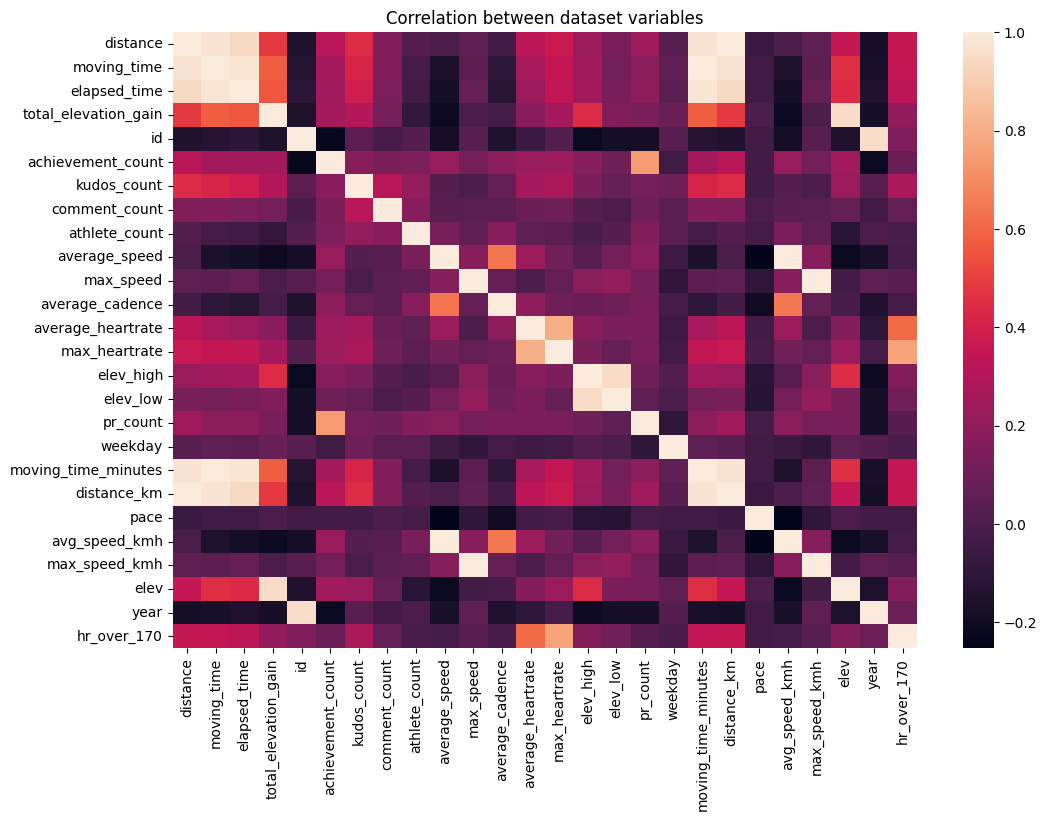

In [236]:
corr = runs.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");
plt.title('Correlation between dataset variables')
plt.show()


In [316]:
df.describe()

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,...,elev_low,pr_count,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
count,1043.000000,1043.000000,1043.000000,1043.000000,1.043000e+03,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,...,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,7707.839885,2148.964525,2358.969319,106.287248,5.683803e+09,1.175455,2.956855,0.042186,2.482263,3.669320,...,931.958006,0.388303,2.511026,35.816117,7.707967,8.230056,13.208399,23.387057,85.377085,2021.090125
std,5864.797058,1609.792781,1772.037450,190.558632,1.695330e+09,2.375679,3.389475,0.313092,3.328240,0.779973,...,269.878915,1.115128,1.783542,26.829781,5.864820,54.523022,2.805241,9.959327,154.628622,0.926020
min,9.800000,19.000000,19.000000,0.000000,3.377431e+09,0.000000,0.000000,0.000000,1.000000,0.014000,...,0.000000,0.000000,0.000000,0.320000,0.010000,2.341346,0.050000,0.000000,0.000000,2020.000000
25%,3221.850000,922.000000,967.000000,9.500000,4.072893e+09,0.000000,0.000000,0.000000,1.000000,3.356000,...,972.200000,0.000000,1.000000,15.365000,3.220000,4.263079,12.080000,17.280000,6.400000,2020.000000
50%,6740.400000,1881.000000,2075.000000,28.500000,5.492600e+09,0.000000,2.000000,0.000000,1.000000,3.668000,...,976.600000,0.000000,2.000000,31.350000,6.740000,4.544643,13.200000,20.020000,13.200000,2021.000000
75%,10120.800000,2929.500000,3244.000000,89.950000,7.192521e+09,1.000000,5.000000,0.000000,3.000000,3.910500,...,979.050000,0.000000,4.000000,48.825000,10.120000,4.966147,14.075000,25.920000,67.000000,2022.000000
max,88685.800000,24506.000000,24709.000000,2645.300000,8.760127e+09,16.000000,29.000000,6.000000,68.000000,7.113000,...,1857.000000,12.000000,6.000000,408.430000,88.690000,1184.333333,25.630000,61.920000,800.900000,2023.000000


In [237]:
runs = runs.sample(frac=1).reset_index(drop=True)

categorical_cols = [col for col in runs.columns if runs[col].dtypes == 'O']

useless_vars = ['id', 'achievement_count', 'kudos_count', 'comment_count', 'pr_count','athlete_count']
tweak_runs = runs.drop(categorical_cols+useless_vars, axis=1)
tweak_runs

,distance,moving_time,elapsed_time,total_elevation_gain,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,hr_over_170
0,6496.2,1694,2108,47.5,3.835,8.608,78.6,155.700000,177.00000,1014.4,977.9,0,28.23,6.50,4.343077,13.82,30.99,36.5,2022,True
1,11308.4,2301,3036,14.7,4.915,6.600,84.9,176.300000,197.00000,960.9,956.9,5,38.35,11.31,3.390805,17.69,23.76,4.0,2021,True
2,23872.3,7756,8027,571.7,3.078,4.900,78.3,164.100000,184.00000,1359.2,976.0,4,129.27,23.87,5.415584,11.08,17.64,383.2,2020,True
3,22998.9,5624,5757,202.2,4.089,5.500,81.8,156.700000,180.00000,1290.9,1120.1,0,93.73,23.00,4.075217,14.72,19.80,170.8,2021,True
4,12800.8,3356,3391,126.2,3.814,5.100,79.3,163.300000,181.00000,1073.6,977.7,5,55.93,12.80,4.369531,13.73,18.36,95.9,2021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,8065.0,2091,2091,16.2,3.857,6.300,79.7,157.200000,167.00000,979.5,970.8,1,34.85,8.06,4.323821,13.88,22.68,8.7,2021,False
910,10570.6,3420,3564,109.2,3.091,7.200,79.2,147.600000,169.00000,989.3,976.6,3,57.00,10.57,5.392621,11.13,25.92,12.7,2020,False
911,11680.5,2908,3111,28.0,4.017,6.100,79.0,151.332293,169.96986,983.4,968.5,0,48.47,11.68,4.149829,14.46,21.96,14.9,2020,False
912,9684.9,2573,2609,27.3,3.764,6.000,80.0,164.100000,178.00000,989.7,970.3,0,42.88,9.68,4.429752,13.54,21.60,19.4,2020,True


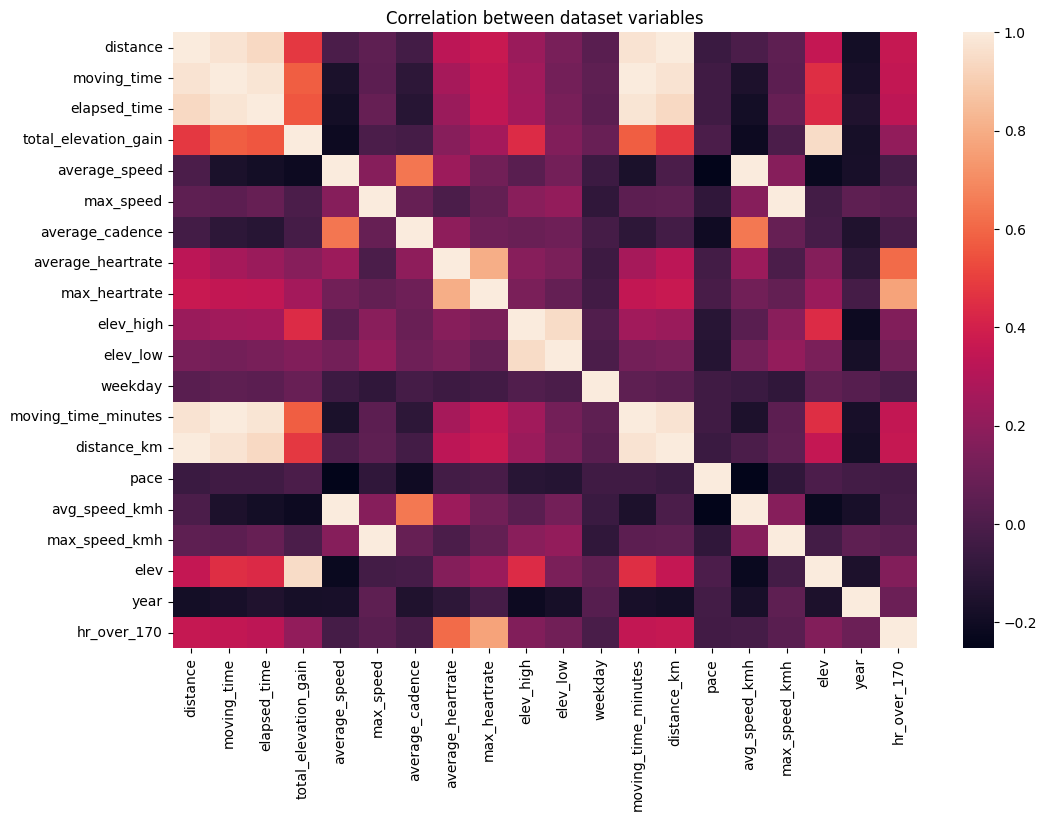

In [317]:
corr = tweak_runs.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");
plt.title('Correlation between dataset variables')
plt.show()

In [238]:
max_hr = df['max_heartrate'].nlargest(10)
print(max_hr)

570    218.0
629    211.0
861    210.0
157    209.0
669    208.0
647    205.0
510    204.0
229    203.0
591    203.0
701    203.0
Name: max_heartrate, dtype: float64


In [279]:
y = tweak_runs['max_heartrate']
X = tweak_runs.drop('max_heartrate',1)

best_features = SelectKBest(chi2, k=7).fit_transform(X, y.astype(int))
best_features

/Users/willd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


array([[6496.2, 1694, 2108, ..., 1014.4, 977.9, 36.5],
       [11308.4, 2301, 3036, ..., 960.9, 956.9, 4.0],
       [23872.3, 7756, 8027, ..., 1359.2, 976.0, 383.20000000000005],
       ...,
       [11680.5, 2908, 3111, ..., 983.4, 968.5, 14.899999999999977],
       [9684.9, 2573, 2609, ..., 989.7, 970.3, 19.40000000000009],
       [6530.0, 1865, 2002, ..., 981.9, 976.5, 5.399999999999977]],
      dtype=object)

In [325]:
def get_best_rfe_features(X,y, model):
    rfe = RFE(model, step=0.05).fit(X, y)
    selected_features = [i for i, j in zip(X.columns, rfe.support_) if j]
    return selected_features

In [326]:
y = tweak_runs['max_heartrate']
X = tweak_runs.drop('max_heartrate',1)

encoded_y = preprocessing.LabelEncoder().fit_transform(y)
model = LinearRegression()
linear_feats = get_best_rfe_features(X, encoded_y, model)
print(linear_feats)

['moving_time', 'average_speed', 'max_speed', 'average_heartrate', 'moving_time_minutes', 'distance_km', 'avg_speed_kmh', 'max_speed_kmh', 'hr_over_170']


/Users/willd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [327]:
y = runs['max_heartrate']
X = runs[linear_feats]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [328]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

MSE: 42.42363687744374


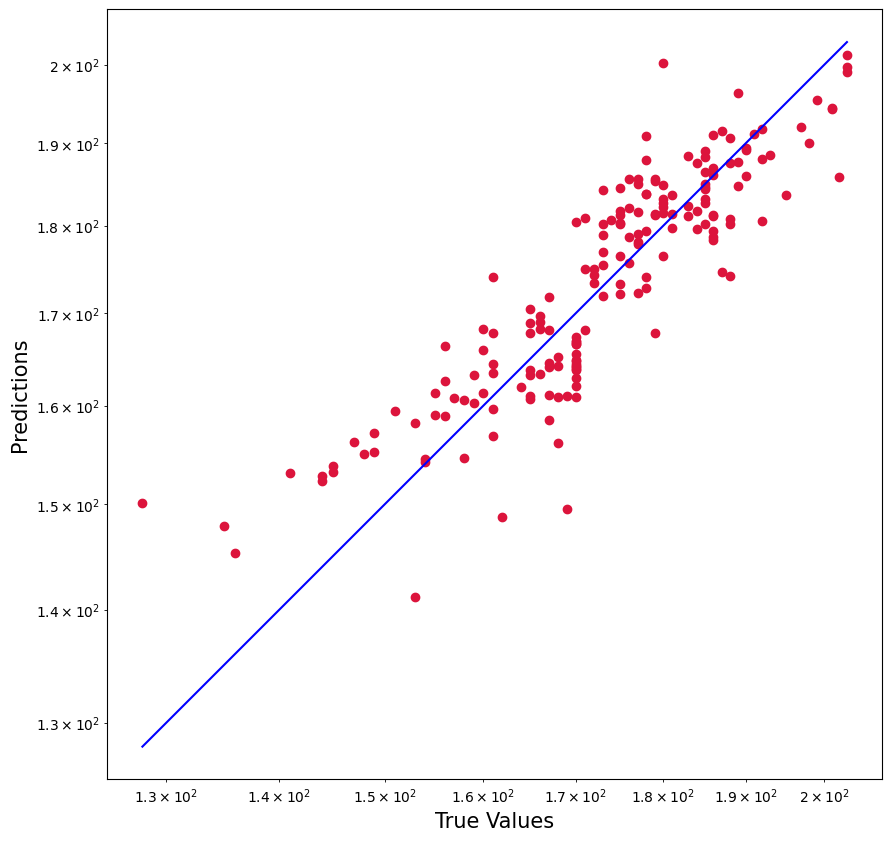

In [329]:
print('MSE:', metrics.mean_squared_error(y_test, y_pred))

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [332]:
model.predict(
    pd.DataFrame(data={
        'moving_time': 114, 
        'average_speed': 6, 
        'max_speed': 6.67, 
        'average_heartrate': 200, 
        'moving_time_minutes': 2, 
        'distance_km': .8, 
        'avg_speed_kmh': 23, 
        'max_speed_kmh': 24, 
        'hr_over_170': True
    },
        index=[0]
    )
)

array([228.45436522])

In [300]:
y = tweak_runs['hr_over_170']
X = tweak_runs.drop('hr_over_170',1)

model = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
class_feats = get_best_rfe_features(X, y, model)
print(class_feats)

['distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'average_heartrate', 'max_heartrate', 'elev_high', 'elev_low', 'year']


/Users/willd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/Users/willd/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/Users/willd/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/Users/willd/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/Users/willd/anaconda3/lib/python3.7/site-pack

In [301]:
y = runs['hr_over_170']
X = runs[class_feats]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [302]:
model = SGDClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

Accuracy: 0.6120218579234973


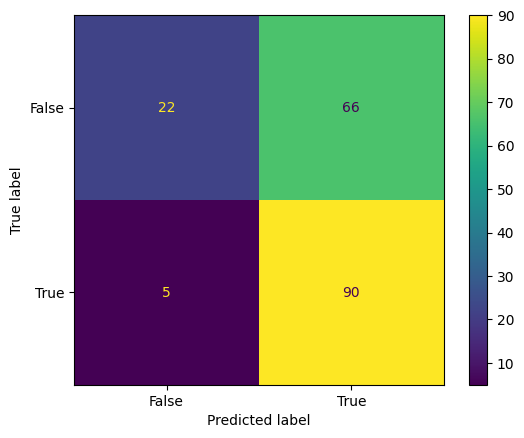

In [303]:
print('Accuracy:', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

disp.plot()
plt.show()

In [312]:
model.predict(
    pd.DataFrame(data={
        'distance': 800, 
        'moving_time': 120, 
        'elapsed_time' : 120, 
        'total_elevation_gain': 0, 
        'average_heartrate': 200, 
        'max_heartrate': 220, 
        'elev_high': 900, 
        'elev_low': 900, 
        'year' : 2023
    },
        index=[0]
    )
)

array([ True])

SGDClassifier()